# HSCT survival kitchen sink linear regression model

## Notebook set-up

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LinearRegression

retrain_models=True
model_file='./models/03.1-linear_regression.pkl'

## 1. Load data

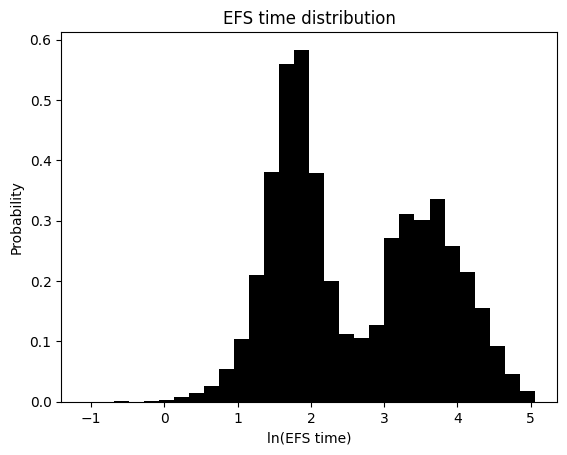

Training features: (28800, 178)


In [2]:
training_features=pd.read_parquet('./data/encoded/training_features_df.parquet')
training_labels=pd.read_parquet('./data/encoded/training_labels_df.parquet')

# Take the log of the labels
training_labels['efs_time']=np.log(training_labels['efs_time'])

# Remove id column from training features
training_features.drop('ID', axis=1, inplace=True)

plt.title('EFS time distribution')
plt.hist(training_labels['efs_time'], density=True, bins=30, color='black')
plt.xlabel('ln(EFS time)')
plt.ylabel('Probability')
plt.show()

print(f'Training features: {training_features.shape}')

## 2. Baseline model

### 2.1. Cross-validation

In [4]:
def cross_val(model, features: pd.DataFrame, labels: pd.Series) -> list[float]:
    '''Reusable helper function to run cross-validation on a model. Takes model,
    Pandas data frame of features and Pandas data series of labels. Returns 
    list of cross-validation fold accuracy scores as percents.'''

    # Define the cross-validation strategy
    cross_validation=KFold(n_splits=7, shuffle=True, random_state=315)

    # Run the cross-validation, collecting the scores
    scores=cross_val_score(
        model,
        features,
        labels,
        cv=cross_validation,
        n_jobs=-1,
        scoring='neg_root_mean_squared_error'
    )

    # Print mean and standard deviation of the scores
    print(f'Cross validation RMSE {-scores.mean():.2f} +/- {scores.std():.2f}')

    # Return the scores
    return scores

# Instantiate default elastic net model
model=LinearRegression()

# Run cross-validation to estimate out-of-sample performance
scores=cross_val(model, training_features, training_labels['efs_time'])

Cross validation RMSE 0.97 +/- 0.01


### 2.2. Training set performance

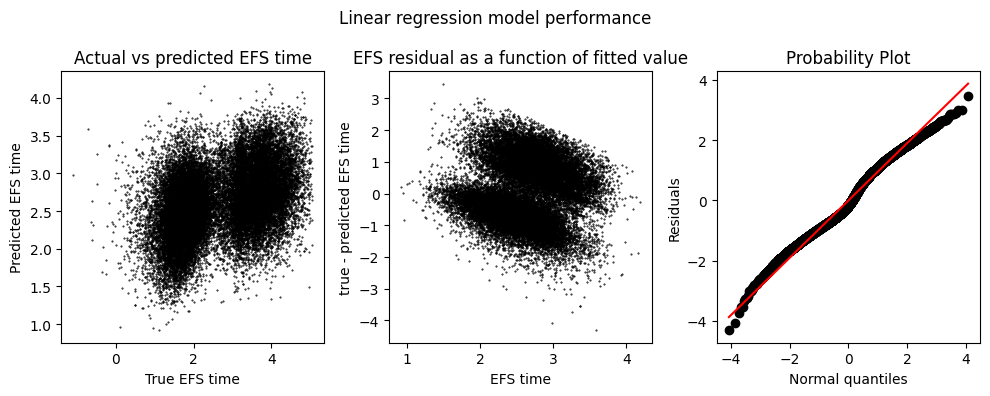

In [5]:
# Train or load model as desired
if retrain_models == True:
    model.fit(training_features, training_labels['efs_time'])

    with open(model_file, 'wb') as output_file:
        pickle.dump(model, output_file)

elif retrain_models == False:
    with open(model_file, 'rb') as input_file:
        model=pickle.load(input_file)

# Make predictions for the whole training set
predicted_efs_time=model.predict(training_features)

# Plot the results
fig, axs=plt.subplots(1,3, figsize=(10,4))
axs=axs.flatten()

fig.suptitle('Linear regression model performance')

axs[0].set_title('Actual vs predicted EFS time')
axs[0].scatter(training_labels['efs_time'], predicted_efs_time, color='black', s=0.2)
axs[0].set_xlabel('True EFS time')
axs[0].set_ylabel('Predicted EFS time')

axs[1].set_title('EFS residual as a function of fitted value')
axs[1].scatter(predicted_efs_time, training_labels['efs_time'] - predicted_efs_time, color='black', s=0.2)
axs[1].set_xlabel('EFS time')
axs[1].set_ylabel('true - predicted EFS time')

axs[2].set_title('Normal quantile plot')
stats.probplot(training_labels['efs_time'] - predicted_efs_time, plot=axs[2])
axs[2].get_lines()[0].set_markeredgecolor('black')
axs[2].get_lines()[0].set_markerfacecolor('black')
axs[2].set_xlabel('Normal quantiles')
axs[2].set_ylabel('Residuals')

plt.tight_layout()
plt.show()

## 3. Interaction features

Cross validation RMSE 4.38 +/- 1.04


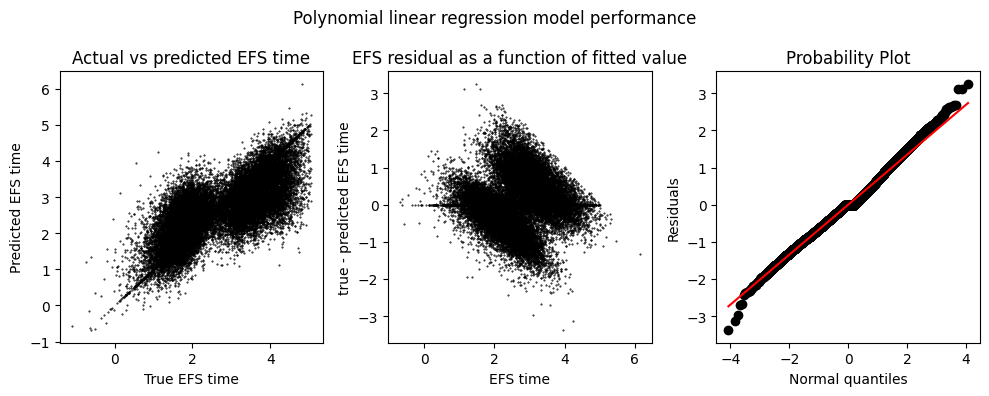

In [7]:
# Use polynomial features transform to add interaction features
poly=PolynomialFeatures(2)
poly.fit(training_features)
training_data=poly.transform(training_features)

# Instantiate the model
model=LinearRegression()
model.fit(training_data, training_labels['efs_time'])

# Run cross-validation to estimate out-of-sample performance
tuned_scores=cross_val(model, training_data, training_labels['efs_time'])

# Make predictions on the training set
predicted_efs_time=model.predict(training_data)

# Plot the results
fig, axs=plt.subplots(1,3, figsize=(10,4))
axs=axs.flatten()

fig.suptitle('Polynomial linear regression model performance')

axs[0].set_title('Actual vs predicted EFS time')
axs[0].scatter(training_labels['efs_time'], predicted_efs_time, color='black', s=0.2)
axs[0].set_xlabel('True EFS time')
axs[0].set_ylabel('Predicted EFS time')

axs[1].set_title('EFS residual as a function of fitted value')
axs[1].scatter(predicted_efs_time, training_labels['efs_time'] - predicted_efs_time, color='black', s=0.2)
axs[1].set_xlabel('EFS time')
axs[1].set_ylabel('true - predicted EFS time')

axs[2].set_title('Normal quantile plot')
stats.probplot(training_labels['efs_time'] - predicted_efs_time, plot=axs[2])
axs[2].get_lines()[0].set_markeredgecolor('black')
axs[2].get_lines()[0].set_markerfacecolor('black')
axs[2].set_xlabel('Normal quantiles')
axs[2].set_ylabel('Residuals')

plt.tight_layout()
plt.show()

In [8]:
# Save assets
poly_model_file='./models/03.2-linear_regression_polynomial_features.pkl'
poly_features_transformer_file='./models/03-poly_features_transformer.pkl'

with open(poly_model_file, 'wb') as output_file:
    pickle.dump(model, output_file)

with open(poly_features_transformer_file, 'wb') as output_file:
    pickle.dump(poly, output_file)

In [10]:
poly_features_data_file='./data/encoded/polynomial_training_features_df.parquet'
poly_features_df=pd.DataFrame(training_data)
poly_features_df.to_parquet(poly_features_data_file)

## 7. Make test set predictions

In [ ]:
testing_features_df=pd.read_parquet('./data/encoded/testing_features_df.parquet')
ids=testing_features_df['ID']
testing_features_df.drop('ID', axis=1, inplace=True)
predicted_efs_time=model.predict(testing_features_df)
scaler=MinMaxScaler()
scaler.fit(predicted_efs_time.reshape(-1, 1))
predicted_efs_time=scaler.transform(predicted_efs_time.reshape(-1, 1))

predictions_df=pd.DataFrame.from_dict({'ID': ids, 'prediction': predicted_efs_time.flatten()})
predictions_df.describe()